In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import statsmodels.api as sm # estimação de modelos
from pymer4.models import Lmer # estimação de modelos HLM3 neste código
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
# import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código

#### ESTIMAÇÃO DE MODELOS HIERÁRQUICOS LINEARES DE DOIS NÍVEIS COM DADOS AGRUPADOS       

In [3]:
# Carregamento da base de dados 'desempenho_aluno_escola'
df_aluno_escola = pd.read_csv('data/desempenho_aluno_escola.csv', delimiter=',')

# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')
modelo_nulo_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ 1', # Componente de Efeito Fixo
                                           groups='escola',
                                           re_formula='1', # Componente de Efeito Aleatório
                                           data=df_aluno_escola).fit()

# Parâmetros do 'modelo_nulo_hlm2'
print(modelo_nulo_hlm2.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          



Interpretação do summary do modelo multinivel:

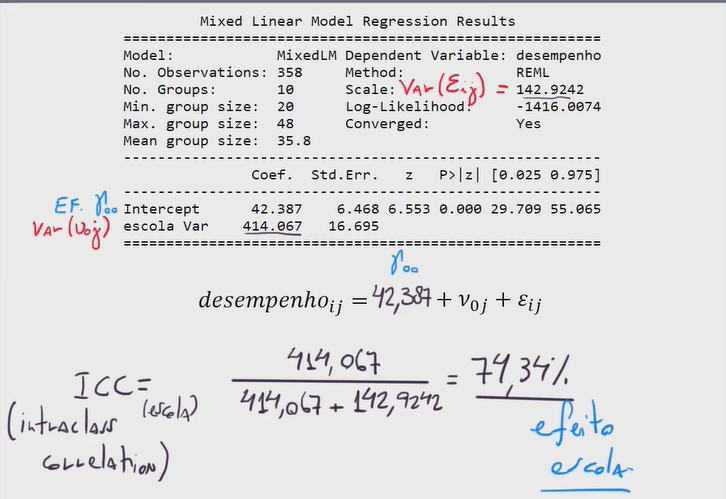

*O teste ICC indica que quase 75% da variação do modelo se deve ao efeito escola!*

In [4]:
# Análise da significância estatística dos efeitos aleatórios de
# intercepto

teste = float(modelo_nulo_hlm2.cov_re.iloc[0, 0]) /\
    float(pd.DataFrame(modelo_nulo_hlm2.summary().tables[1]).iloc[1, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

Estatística z para a Significância dos Efeitos Aleatórios: 24.802
P-valor: 0.000
Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.


#### COMPARAÇÃO DO HLM2 NULO COM UM OLS NULO                  

In [5]:
# Estimação de um modelo OLS nulo

modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df_aluno_escola).fit()

# Parâmetros do 'modelo_ols_nulo'
print(modelo_ols_nulo.summary())

                            OLS Regression Results                            
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                ter, 17 set 2024   Prob (F-statistic):                nan
Time:                        22:46:35   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5542      1.228     33.852      0.0

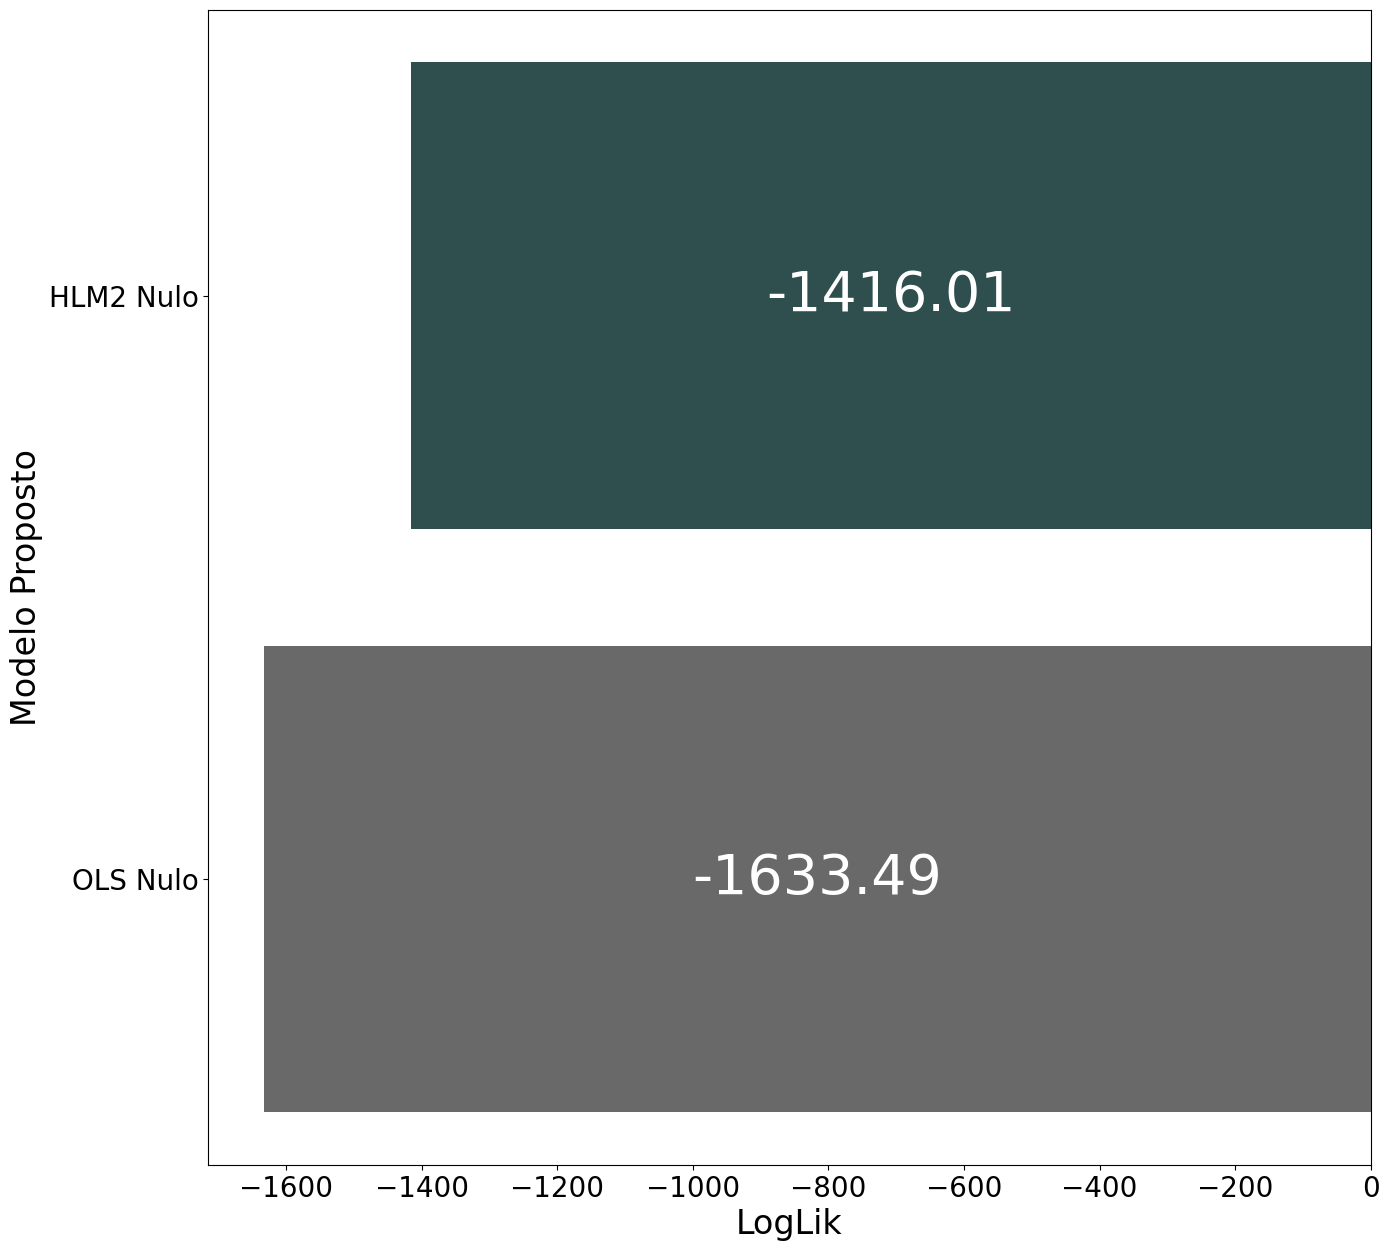

In [6]:
# Gráfico para comparação visual dos logLiks dos modelos estimados
# até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [7]:
# Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o
# 'modelo_ols_nulo'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [8]:
# Teste de de razão de verossimilhança para comparar as estimações
# dos 'modelo_ols_nulo' e 'modelo_nulo_hlm2'

lrtest([modelo_ols_nulo, modelo_nulo_hlm2])

Likelihood Ratio Test:
-2.(LL0-LLm): 434.96
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood
